In [6]:
import numpy as np
import networkx as nx
import scipy as sp
import pickle
import plotly.graph_objects as go
import matplotlib.pyplot as plt

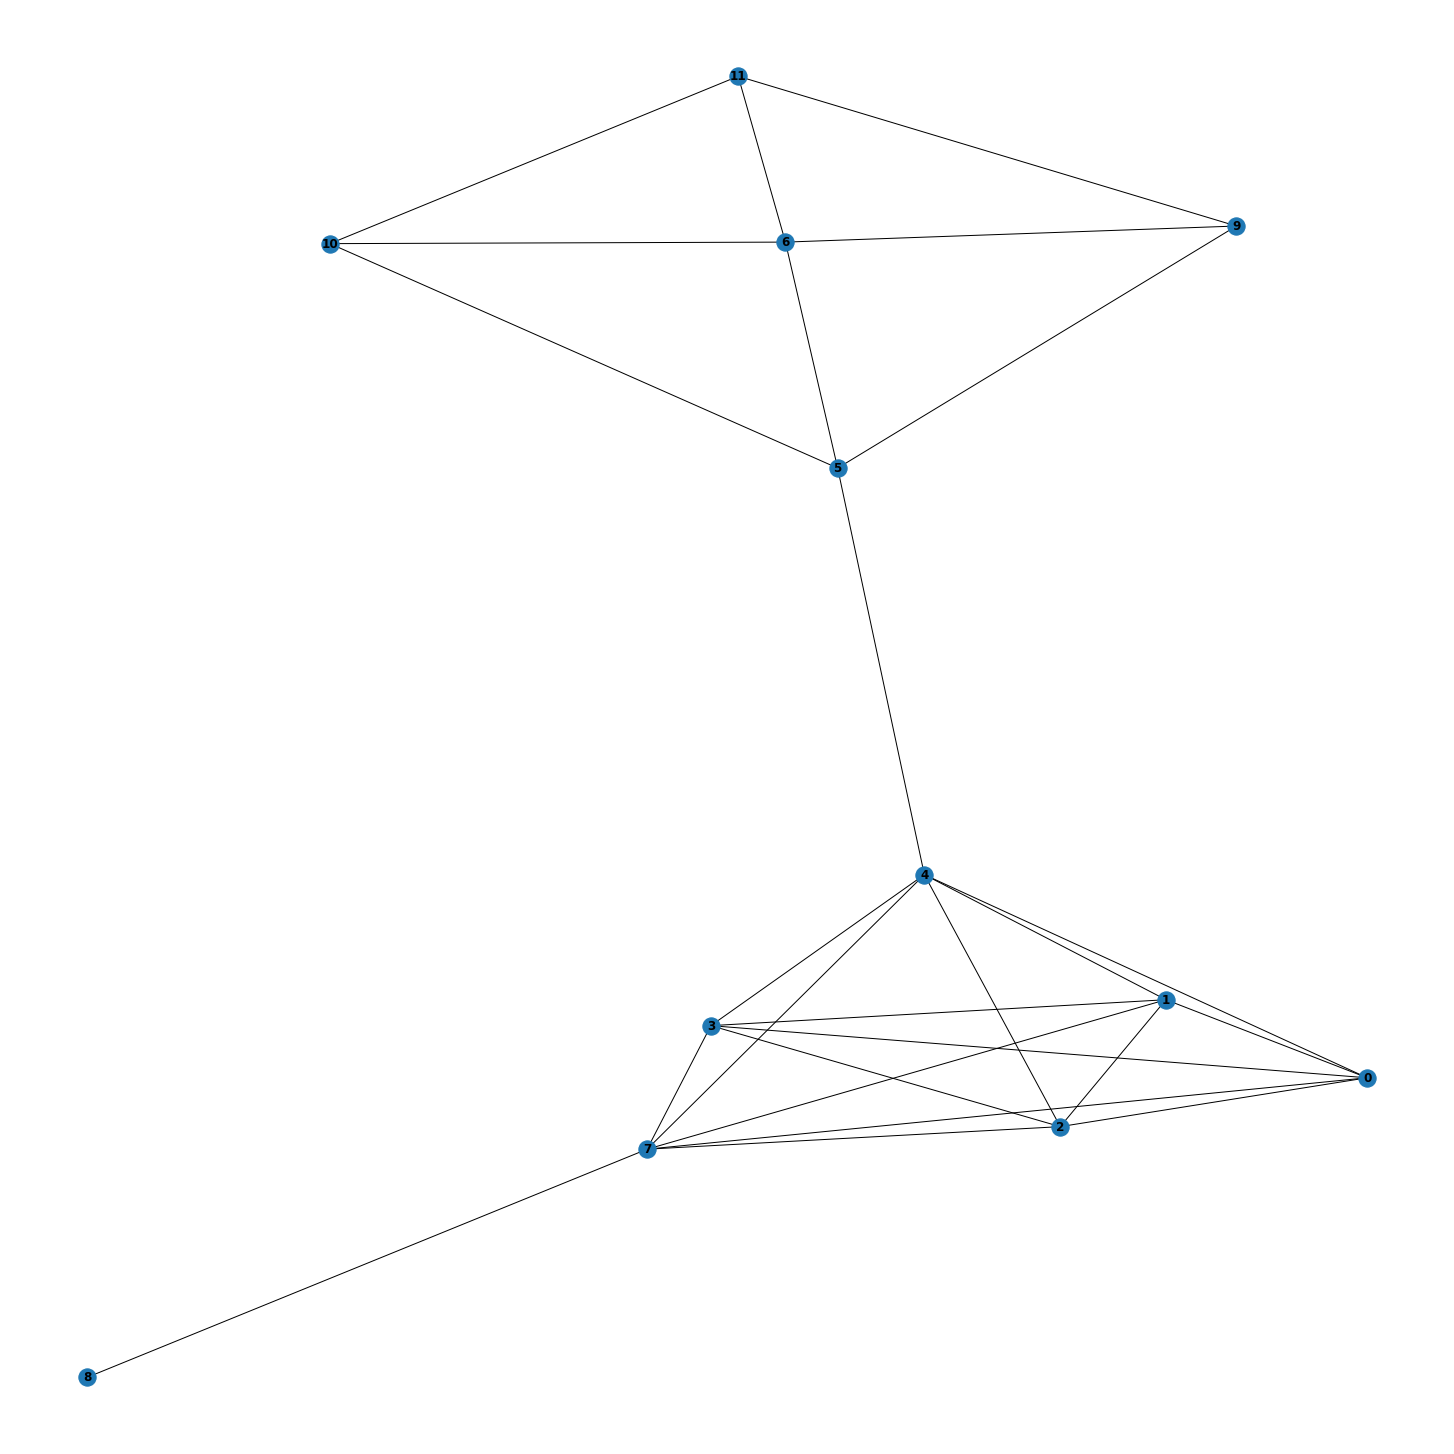

In [24]:
tr = 0.3
nodes = [0,1,2,3,4,5,6,7,8,9]
edges = [(0,1),(0,2),(0,3),(0,4),(0,7),
         (1,2),(1,3),(1,4),(1,7),
         (2,3),(2,4),(2,7),
         (3,4),(3,7),
         (4,7),
         (4,5),
         (5,6),(5,9),(5,10),
         (6,9),(6,10),(6,11),
         (7,8),
         (9,11),
         (10,11),
        ]

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True, font_weight='bold')

In [3]:
list(G.nodes).index(2)

2

In [4]:
A = nx.adjacency_matrix(G)
A = A.todense()
A

matrix([[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]], dtype=int64)

In [32]:
from collections import defaultdict
from scipy.sparse import csr_matrix, spmatrix

def getSimilarity(fp, vec):
    return vec.dot(fp).max() / vec.sum()

def updateFingerprint(fp, vec, count):
    if isinstance(vec, spmatrix):
        return (fp * ((count - 1) / count)) + (vec.A.astype(np.float) * (1 / count))
    else:
        return (fp * ((count - 1) / count)) + (vec * (1 / count))

def findClusters(g, threshold=0.3):
    ''' fingerprint map
    {
        fp_index: [
            row_index,
            ...
        ],
        ...
    }
    '''
    fmap = defaultdict(list)
    matrix = nx.to_numpy_matrix(g)

    ''' fingerprints '''
    fps = []

    for ri, node in enumerate(g.nodes):
        row = matrix[ri]
        
        # initialize fingerprints
        if len(fps) == 0:
            fmap[len(fps)].append(node)
            fps.append(row.A[0].astype(np.float))
            continue
        
        # get best scoring fingerprint
        score, fi, fp = sorted([(getSimilarity(fp, row), fi, fp) for fi, fp in enumerate(fps)]).pop() 
        
        if score > threshold:
            # map node to fingerprint
            fmap[fi].append(node)
            # update fingerprint with row weights
            fp[:] = updateFingerprint(fp, row, len(fmap[fi]))
            
        else:
            fmap[len(fps)].append(node)
            fps.append(row.A[0].astype(np.float))
      
        
#         match = False
#         for fi, fp in enumerate(fingerprints[:]):
#             score = getSimilarity(fp, row)

#             if score > threshold:
#                 # map row to fingerprint
#                 fmap[fi].append(node)
#                 # update this fingerprint with row weights
#                 fp[:] = updateFingerprint(fp, row, len(fmap[fi]))
#                 match = True

#         if not match:
#             fmap[len(fingerprints)].append(node)
#             fingerprints.append(row.A[0].astype(np.float))
            
    return fps, fmap

def mergeFingerprints(fps, fmap, threshold=0.3):
    merged_fps = []
    merged_fmap = {}

    processed = []
    for ai, afp in enumerate(fps):
        # skip fingerprints that have already been merged
        if ai in processed: continue

        # get best scoring fingerprint
        score, bi, bfp = sorted([(getSimilarity(afp, bfp), bi, bfp) for bi, bfp in enumerate(fps) if bi != ai]).pop()

        # same for second fingerprint
        if bi in processed: continue

        if score > threshold:
            # merge fingerprints
            fp = updateFingerprint(afp, bfp, 2)
            merged_fps.append(fp)
            # merge node references
            i = len(merged_fps) - 1
            merged_fmap[i] = list(set(fmap[ai] + fmap[bi]))
            # mark as processed
            processed += [ai, bi]
            
    # add fingerprints that were not merged
    for i, fp in enumerate(fps):
        if i not in processed:
            merged_fps.append(fp)
            merged_fmap[len(merged_fps) - 1] = fmap[i]

    return merged_fps, merged_fmap

def drawClusters(g, fmap):
    nodes = list(g.nodes)
    
    order = []
    for ci, cnodes in sorted(fmap.items()):
        for cnode in cnodes:
            order.append(nodes.index(cnode))
            
    matrix = nx.to_numpy_array(g)[order][:,order]
    x, y = np.argwhere(matrix == 1).T
    
#     fig = go.Figure(data=go.Scatter(
#         x=x,
#         y=y,
#         mode='markers'
#     ))
    
#     fig.show()

    plt.scatter(x, y, s=0.1)
    plt.show()
    
    return matrix, x, y
                
# fps, fmap = findClusters(G)

In [3]:
graph = nx.read_gpickle('/mnt/d/Datasets/harvey_streams/2017-08-17-001003.pkl')

In [41]:
fps, fmap = findClusters(graph, 0.05)

In [42]:
len(fmap)

6

In [43]:
merged_fps, merged_fmap = mergeFingerprints(fps, fmap, 0.005)

In [44]:
len(merged_fmap)

3

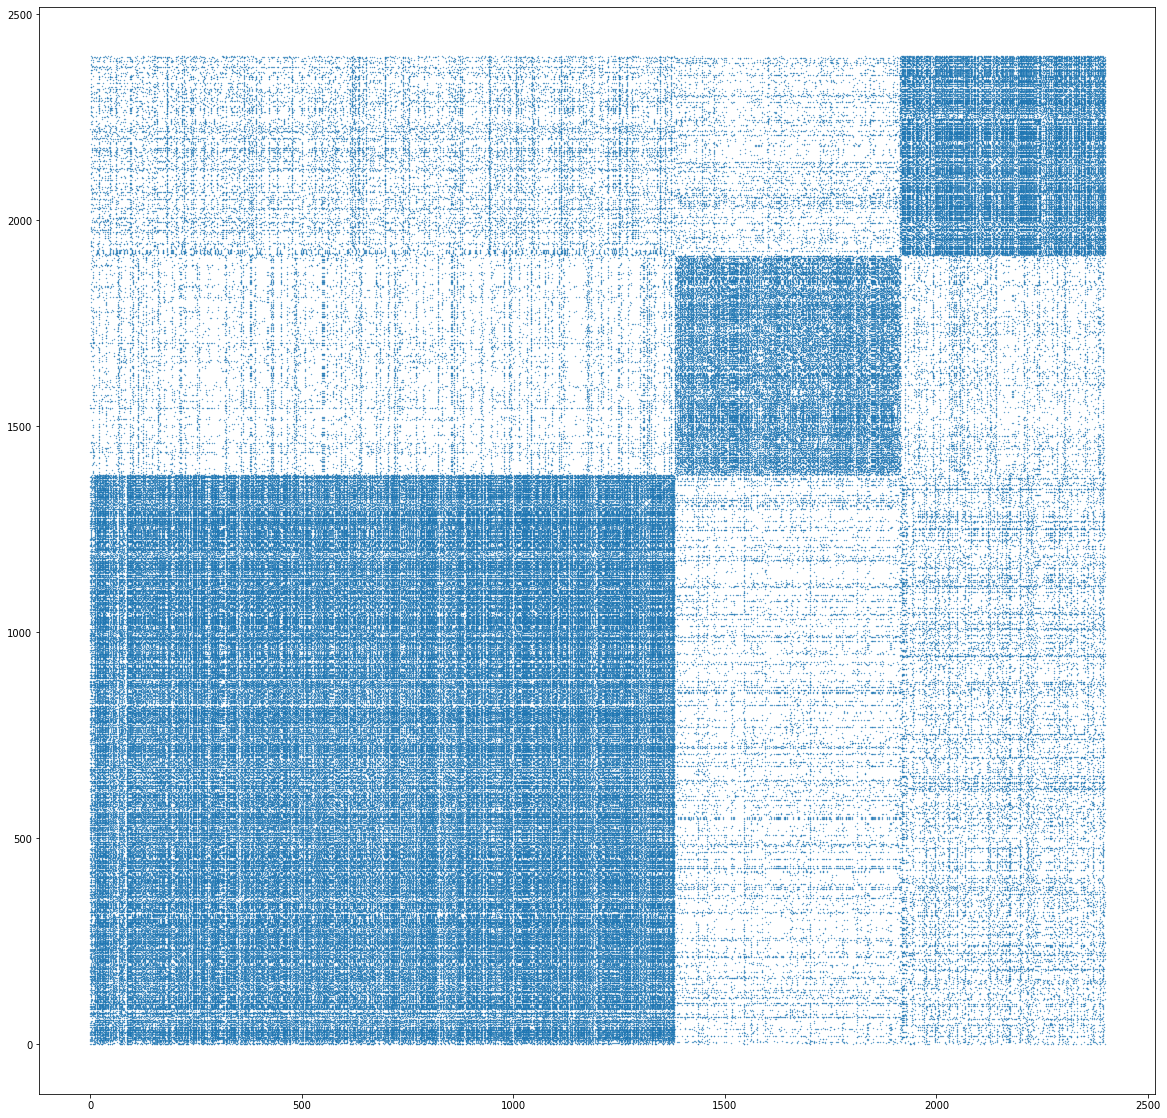

In [45]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20)

m, x, y = drawClusters(graph, merged_fmap)

In [19]:
m.shape

(4381, 2399)

In [15]:
nx.to_numpy_array(graph).shape

(2399, 2399)

In [35]:
{k: len(v) for k, v in fmap.items()}

{0: 357,
 1: 43,
 2: 79,
 3: 70,
 4: 15,
 5: 80,
 6: 3,
 7: 11,
 8: 165,
 9: 71,
 10: 9,
 11: 457,
 12: 200,
 13: 9,
 14: 10,
 15: 33,
 16: 11,
 17: 52,
 18: 64,
 19: 5,
 20: 14,
 21: 37,
 22: 14,
 23: 2,
 24: 23,
 25: 31,
 26: 103,
 27: 3,
 28: 9,
 29: 65,
 30: 23,
 31: 6,
 32: 27,
 33: 5,
 34: 18,
 35: 18,
 36: 13,
 37: 8,
 38: 1,
 39: 29,
 40: 18,
 41: 33,
 42: 6,
 43: 17,
 44: 13,
 45: 2,
 46: 21,
 47: 8,
 48: 17,
 49: 5,
 50: 6,
 51: 15,
 52: 5,
 53: 22,
 54: 4,
 55: 10,
 56: 2,
 57: 2}